In [1]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=4

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=4


In [2]:
import mbuild as mb
import foyer
import mosdef_cassandra as mc
import unyt as u
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import numpy as np

from scipy.stats import linregress

from mosdef_cassandra.analysis import ThermoProps
from mosdef_cassandra.utils.tempdir import temporary_cd

# Filter some warnings -- to cleanup output for this demo
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)
from parmed.exceptions import OpenMMWarning
filterwarnings('ignore', category=OpenMMWarning)
warnings.filterwarnings('ignore')


mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False

mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

%matplotlib inline



def set_ticks(ax, xlinear=True, ylinear=False, xmax=False, ymax=True, yticks = 5, xticks = 5):
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    if xlinear: ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(xticks))
    if xmax: ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(xticks))
    if ylinear: ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(yticks))
    if ymax: ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(yticks))


In [3]:
class CentralCH2(mb.Compound):
    def __init__(self):
        super(CentralCH2, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_CH2')
        self.add(bead)
        up_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.077)
        down_port = mb.Port(anchor=bead, orientation=[0, 0, -1], separation=0.077)
        self.add(up_port, label='up')
        self.add(down_port, label='down')



        
class TerminalCH3(mb.Compound):
    def __init__(self):
        super(TerminalCH3, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_CH3')
        self.add(bead)

        cap_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.077)
        self.add(cap_port, label='cap')
        
class TerminalCH2(mb.Compound):
    def __init__(self):
        super(TerminalCH3, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_CH2')
        self.add(bead)

        cap_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.077)
        self.add(cap_port, label='cap')
        
class CentralCH(mb.Compound):
    def __init__(self):
        super(CentralCH2, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_CH')
        self.add(bead)
        up_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.077)
        down_port = mb.Port(anchor=bead, orientation=[0, 0, -1], separation=0.077)
        self.add(up_port, label='up')
        self.add(down_port, label='down')
        

class TraPPE_Alkane(mb.Compound):
    def __init__(self, chain_length):
        super(TraPPE_Alkane, self).__init__()
        
        terminal_bead = TerminalCH3()
        last_unit = CentralCH2()
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['up'])
        self.add(last_unit)
        self.add(terminal_bead)   
        for _ in range(chain_length - 3):
            current_unit = CentralCH2()
            mb.force_overlap(move_this=current_unit,
                             from_positions=current_unit['up'],
                             to_positions=last_unit['down'])
            self.add(current_unit)
            last_unit=current_unit
        terminal_bead = TerminalCH3()
        
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['down'])
        self.add(terminal_bead, label='down-cap')
        if chain_length < 3:
            print("Note, the shortest chain this function will make is 3")
                     

class TraPPE_Alkene(mb.Compound):
    def __init__(self, chain_length):
        super(TraPPE_Alkane, self).__init__()
        
        terminal_bead = TerminalCH3()
        last_unit = CentralCH2()
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['up'])
        self.add(last_unit)
        self.add(terminal_bead)   
        for _ in range(chain_length - 4):
            current_unit = CentralCH2()
            mb.force_overlap(move_this=current_unit,
                             from_positions=current_unit['up'],
                             to_positions=last_unit['down'])
            self.add(current_unit)
            last_unit=current_unit
            
        current_unit = CentralCH()
        mb.force_overlap(move_this=current_unit,
                         from_positions=current_unit['up'],
                         to_positions=last_unit['down'])
        self.add(current_unit)
        last_unit=current_unit
        
        terminal_bead = TerminalCH2()
        
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['down'])
        self.add(terminal_bead, label='down-cap')
        
        if chain_length < 3:
            print("Note, the shortest chain this function will make is 3")
                

class TraPPE_MeOH(mb.Compound):
    def __init__(self):
        super(TraPPE_MeOH, self).__init__()
        
        methyl = mb.Particle(name='_CH3', pos=[0.0, 0.0, 0.0])
        oxygen = mb.Particle(name='O', pos=[0.0, 0.0, 0.143])
        hydrogen = mb.Particle(name='H', pos=[0.0, 0, 0.143 + 0.0945])

        self.add(methyl)
        self.add(oxygen)
        self.add(hydrogen)
        
        self.add_bond((self[0], self[1]))
        self.add_bond((self[1], self[2]))


In [4]:

adsorbate = TraPPE_Alkane(6)
ff = foyer.forcefields.load_TRAPPE_UA()
adsorbate_ff = ff.apply(adsorbate)
adsorbate.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
zeolite_lattice = mb.lattice.load_cif('Beta_A.cif')
compound_dict = {
    "O" : mb.Compound(name="O"),
    "Si" : mb.Compound(name="Si")
}


nx = 1
ny = 1
nz = 1

zeolite = zeolite_lattice.populate(x=nx, y=ny, z=nz, compound_dict=compound_dict)

trappe_zeo = foyer.Forcefield("zeo_trappe.xml")
zeolite_ff = trappe_zeo.apply(zeolite)

zeolite.visualize()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
box_list = [zeolite]
species_list = [zeolite_ff, adsorbate_ff]

mols_in_boxes = [[1,0]]
mols_to_add=[[0,1]]

system = mc.System(
    box_list,
    species_list,
    mols_in_boxes=mols_in_boxes,
    mols_to_add=mols_to_add,
    
)

moveset = mc.MoveSet('nvt', species_list)


custom_args = {
    "charge_style": "none",
    "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 6.0 * u.angstrom,
    #"charge_cutoff": 6.0 * u.angstrom,
    "prop_freq": 1,
    "coord_freq": 1,
}


mc.run(
        system=system,
        moveset=moveset,
        run_type="equil",
        run_length=5000,
        temperature=(550.0 + 273.15) * u.K,
            **custom_args
)

Treating <Structure 192 atoms; 1 residues; 0 bonds; PBC (orthogonal); parameterized> as a non-insertable rigid species since it has no bonds
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


In [6]:
'''
# Create two empty mbuild.Box
# (vapor = larger, liquid = smaller)
#liquid_box = mb.Box(lengths=[3.5, 3.5, 3.5])
#vapor_box = mb.Box(lengths=[4.0, 4.0, 4.0])


liquid_box = mb.fill_box(compound=adsorbate,
                      n_compounds=1024,
                      box=[4.5, 4.5, 4.5]
                      )
#vapor_box = mb.fill_box(compound=adsorbate,
#                      n_compounds=256,
#                      box=[4.5, 4.5, 4.5]
#                      )


mols_in_boxes = [[1,0], [0, 1024]]

# Create box and species list

box_list = [zeolite, liquid_box]

#box_list = [liquid_box, vapor_box]

species_list = [zeolite_ff, adsorbate_ff]
#species_list = [adsorbate_ff]
#mols_to_add = [[500], [12]]

system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)

#moveset = mc.MoveSet("gemc_npt", species_list)
#moveset.max_volume = np.array([0.0, 5000.0]) * u.angstrom**3

moveset.print()
'''

'\n# Create two empty mbuild.Box\n# (vapor = larger, liquid = smaller)\n#liquid_box = mb.Box(lengths=[3.5, 3.5, 3.5])\n#vapor_box = mb.Box(lengths=[4.0, 4.0, 4.0])\n\n\nliquid_box = mb.fill_box(compound=adsorbate,\n                      n_compounds=1024,\n                      box=[4.5, 4.5, 4.5]\n                      )\n#vapor_box = mb.fill_box(compound=adsorbate,\n#                      n_compounds=256,\n#                      box=[4.5, 4.5, 4.5]\n#                      )\n\n\nmols_in_boxes = [[1,0], [0, 1024]]\n\n# Create box and species list\n\nbox_list = [zeolite, liquid_box]\n\n#box_list = [liquid_box, vapor_box]\n\nspecies_list = [zeolite_ff, adsorbate_ff]\n#species_list = [adsorbate_ff]\n#mols_to_add = [[500], [12]]\n\nsystem = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)\n\n#moveset = mc.MoveSet("gemc_npt", species_list)\n#moveset.max_volume = np.array([0.0, 5000.0]) * u.angstrom**3\n\nmoveset.print()\n'

In [7]:
'''
temperature = 373.0 * u.K
pressure = 1.0 *u.bar

custom_args = {
    
    "charge_style": "ewald",
    "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 14.0 * u.angstrom,
    "units": "sweeps",
    "steps_per_sweep": 512,

}

dirname = f'zeolite_gemc_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
if not os.path.isdir(dirname):
    os.mkdir(dirname)
else:
    pass
with temporary_cd(dirname):
    
    mc.run(
        run_name = "equil",
        system=system,
        moveset=moveset,
        run_type="equilibration",
        run_length=10000,
        temperature=temperature,
        pressure = pressure,
        **custom_args,
    )
    
    # Update run_name and restart_name
    custom_args["run_name"] = "prod"
    custom_args["restart_name"] = "equil"
    
    mc.restart(
        run_name = "prod",
        restart_from = "equil",
        run_type="production",
        run_length=20000,

    )
'''

'\ntemperature = 373.0 * u.K\npressure = 1.0 *u.bar\n\ncustom_args = {\n    \n    "charge_style": "ewald",\n    "rcut_min": 0.5 * u.angstrom,\n    "vdw_cutoff": 14.0 * u.angstrom,\n    "units": "sweeps",\n    "steps_per_sweep": 512,\n\n}\n\ndirname = f\'zeolite_gemc_T_{temperature:.1f}\'.replace(" ", "_").replace("/", "-")\nif not os.path.isdir(dirname):\n    os.mkdir(dirname)\nelse:\n    pass\nwith temporary_cd(dirname):\n    \n    mc.run(\n        run_name = "equil",\n        system=system,\n        moveset=moveset,\n        run_type="equilibration",\n        run_length=10000,\n        temperature=temperature,\n        pressure = pressure,\n        **custom_args,\n    )\n    \n    # Update run_name and restart_name\n    custom_args["run_name"] = "prod"\n    custom_args["restart_name"] = "equil"\n    \n    mc.restart(\n        run_name = "prod",\n        restart_from = "equil",\n        run_type="production",\n        run_length=20000,\n\n    )\n'

In [11]:
temperature = 323.0 * u.K

custom_args = {
  "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 14.0 * u.angstrom,
    "charge_cutoff": 14.0 * u.angstrom,
        "prop_freq": 1000,
    "coord_freq": 1000,
}

mus_adsorbate = np.arange(-48, -38, 2) * u.kJ/u.mol


In [12]:



for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        species_list = [adsorbate_ff]
        if mu_adsorbate < -36:
            boxl = 10. # nm
        else:
            boxl = 2.5 # nm
        box_list = [mb.Box([boxl,boxl,boxl])]
        system = mc.System(box_list, species_list)
        moveset = mc.MoveSet('gcmc', species_list)

        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            temperature=temperature,
            chemical_potentials = [mu_adsorbate],
            **custom_args
        )

Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the fol

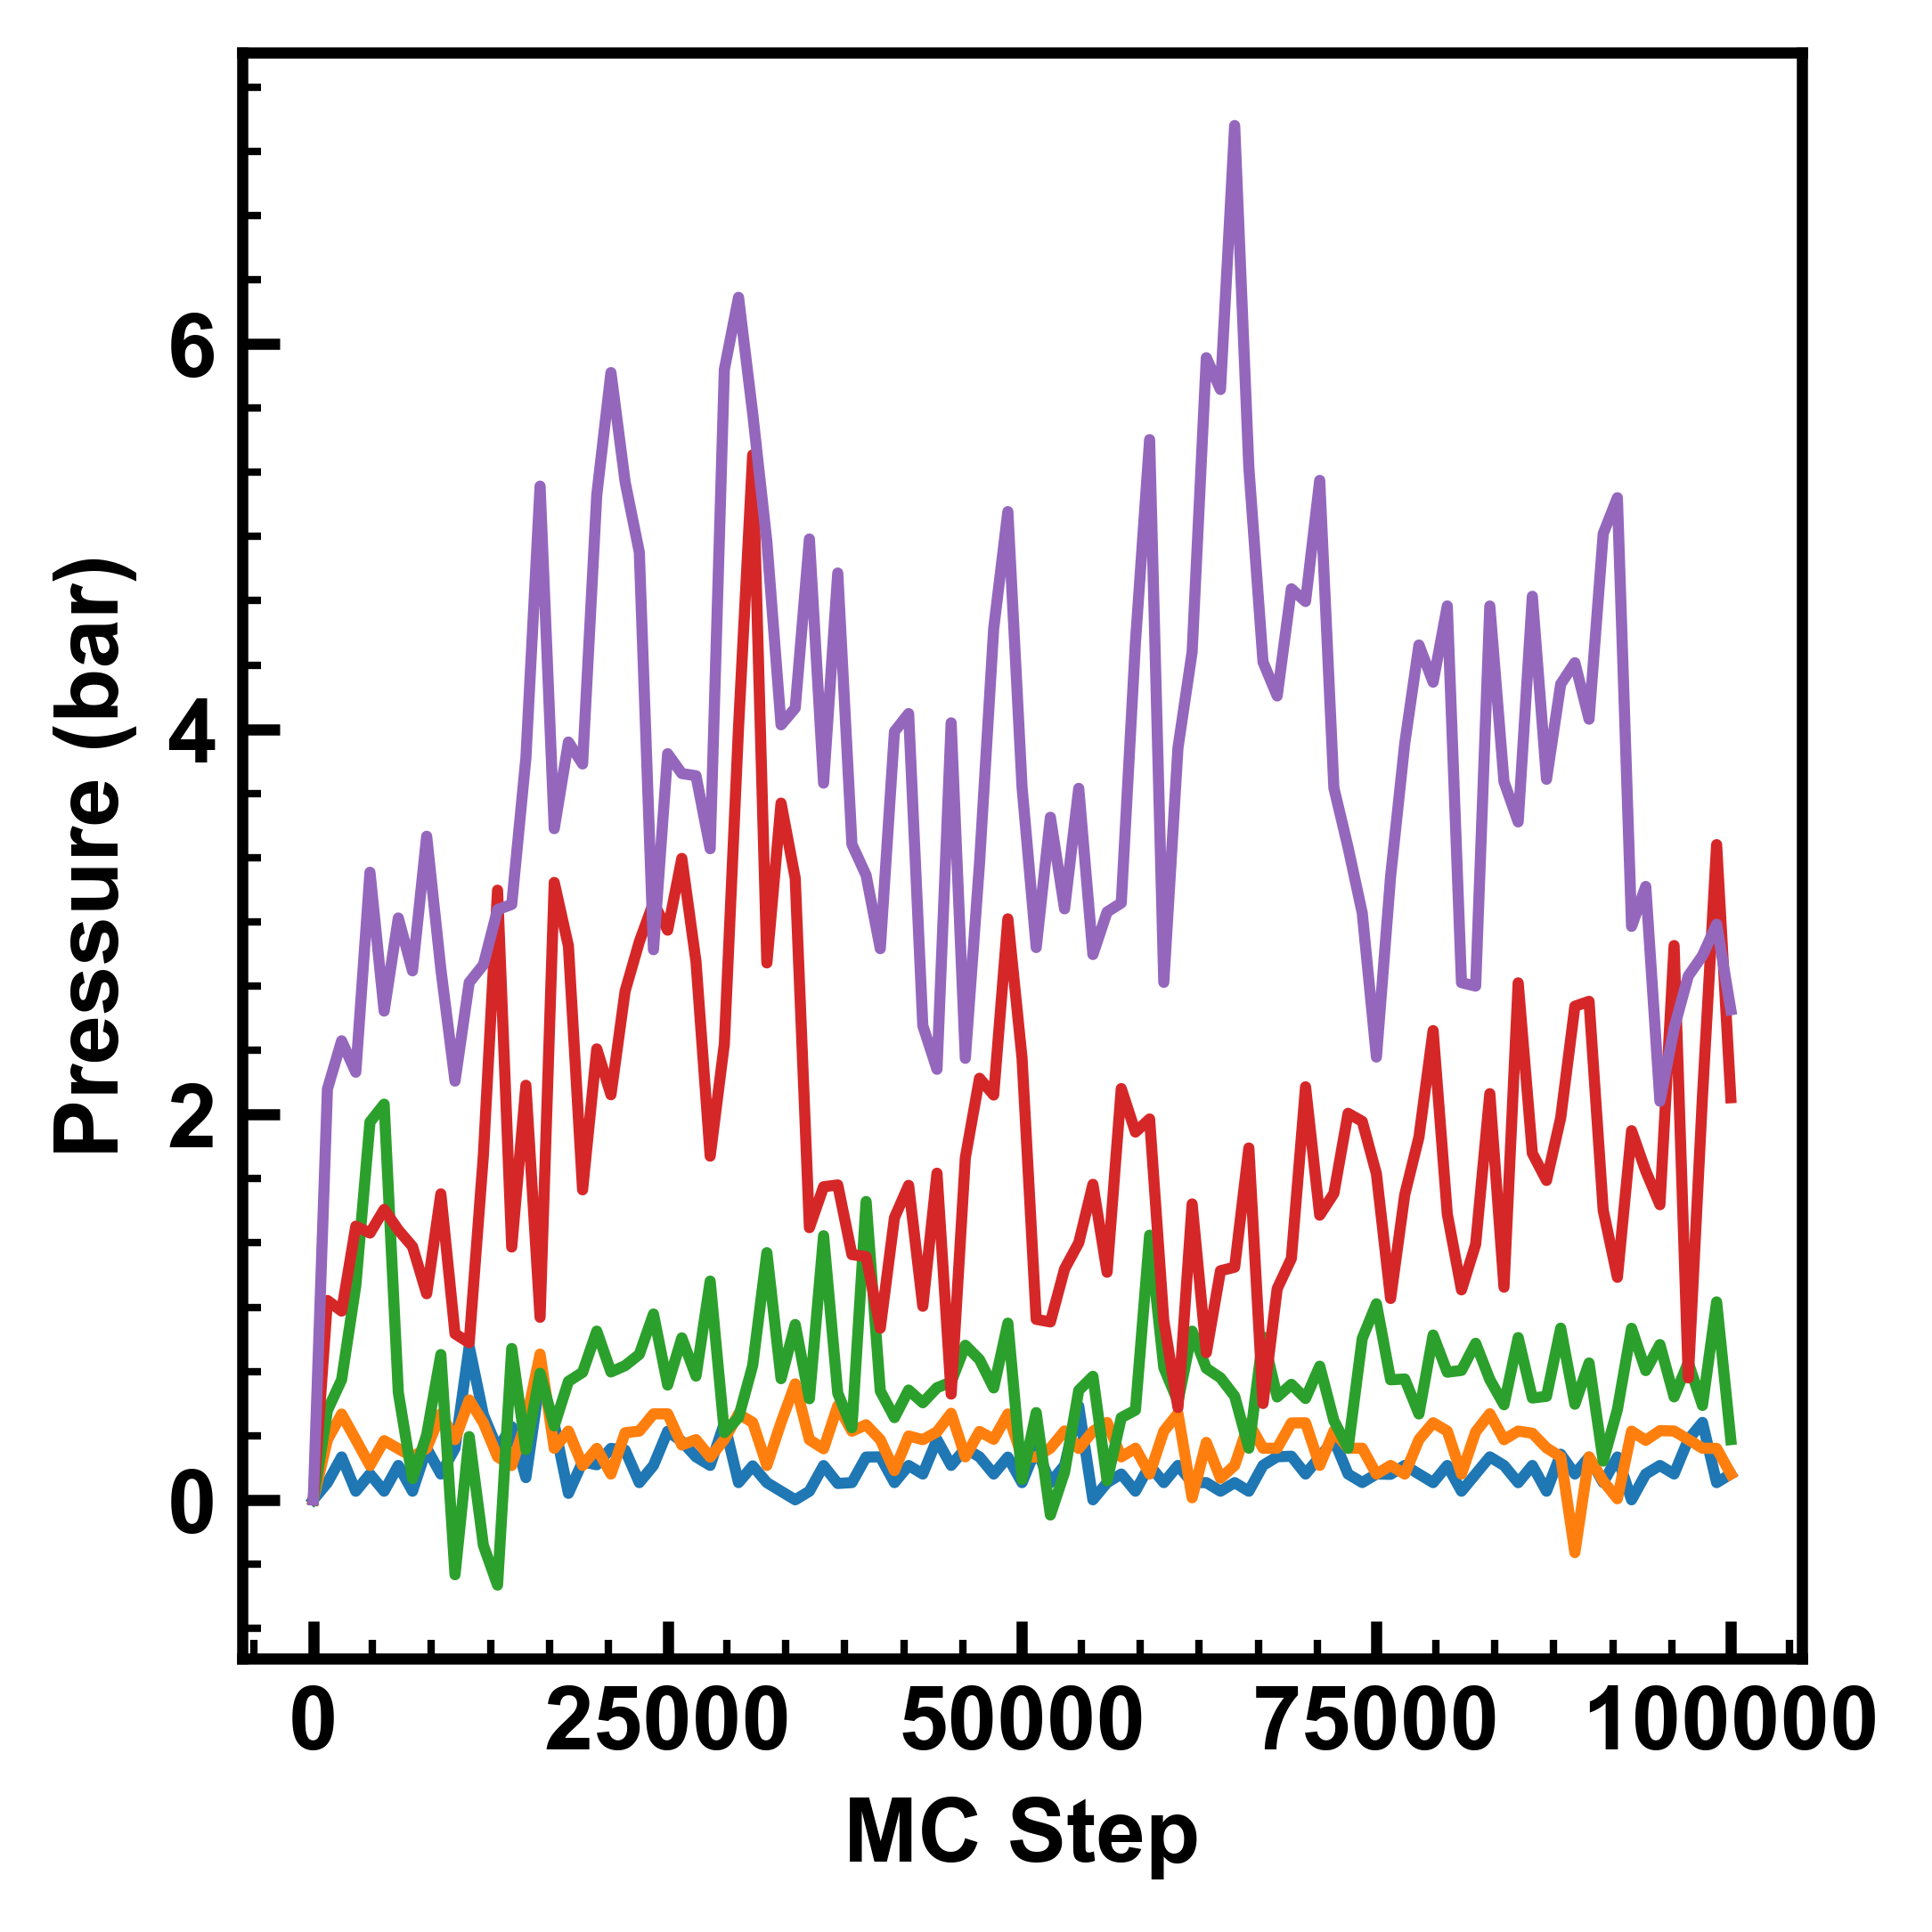

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600, figsize = (3.5, 3.5), layout = "constrained")

pressures = []
for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(dirname + "/gcmc.out.prp")
    pressures.append(np.mean(thermo.prop("Pressure", start=30000)))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Pressure"))
    
ax.set_xlabel("MC Step")
ax.set_ylabel("Pressure (bar)")
set_ticks(ax,  xlinear=False, ylinear=False, xmax=True, ymax=True,)

pass


2.386161180828142
-43.204238607240505


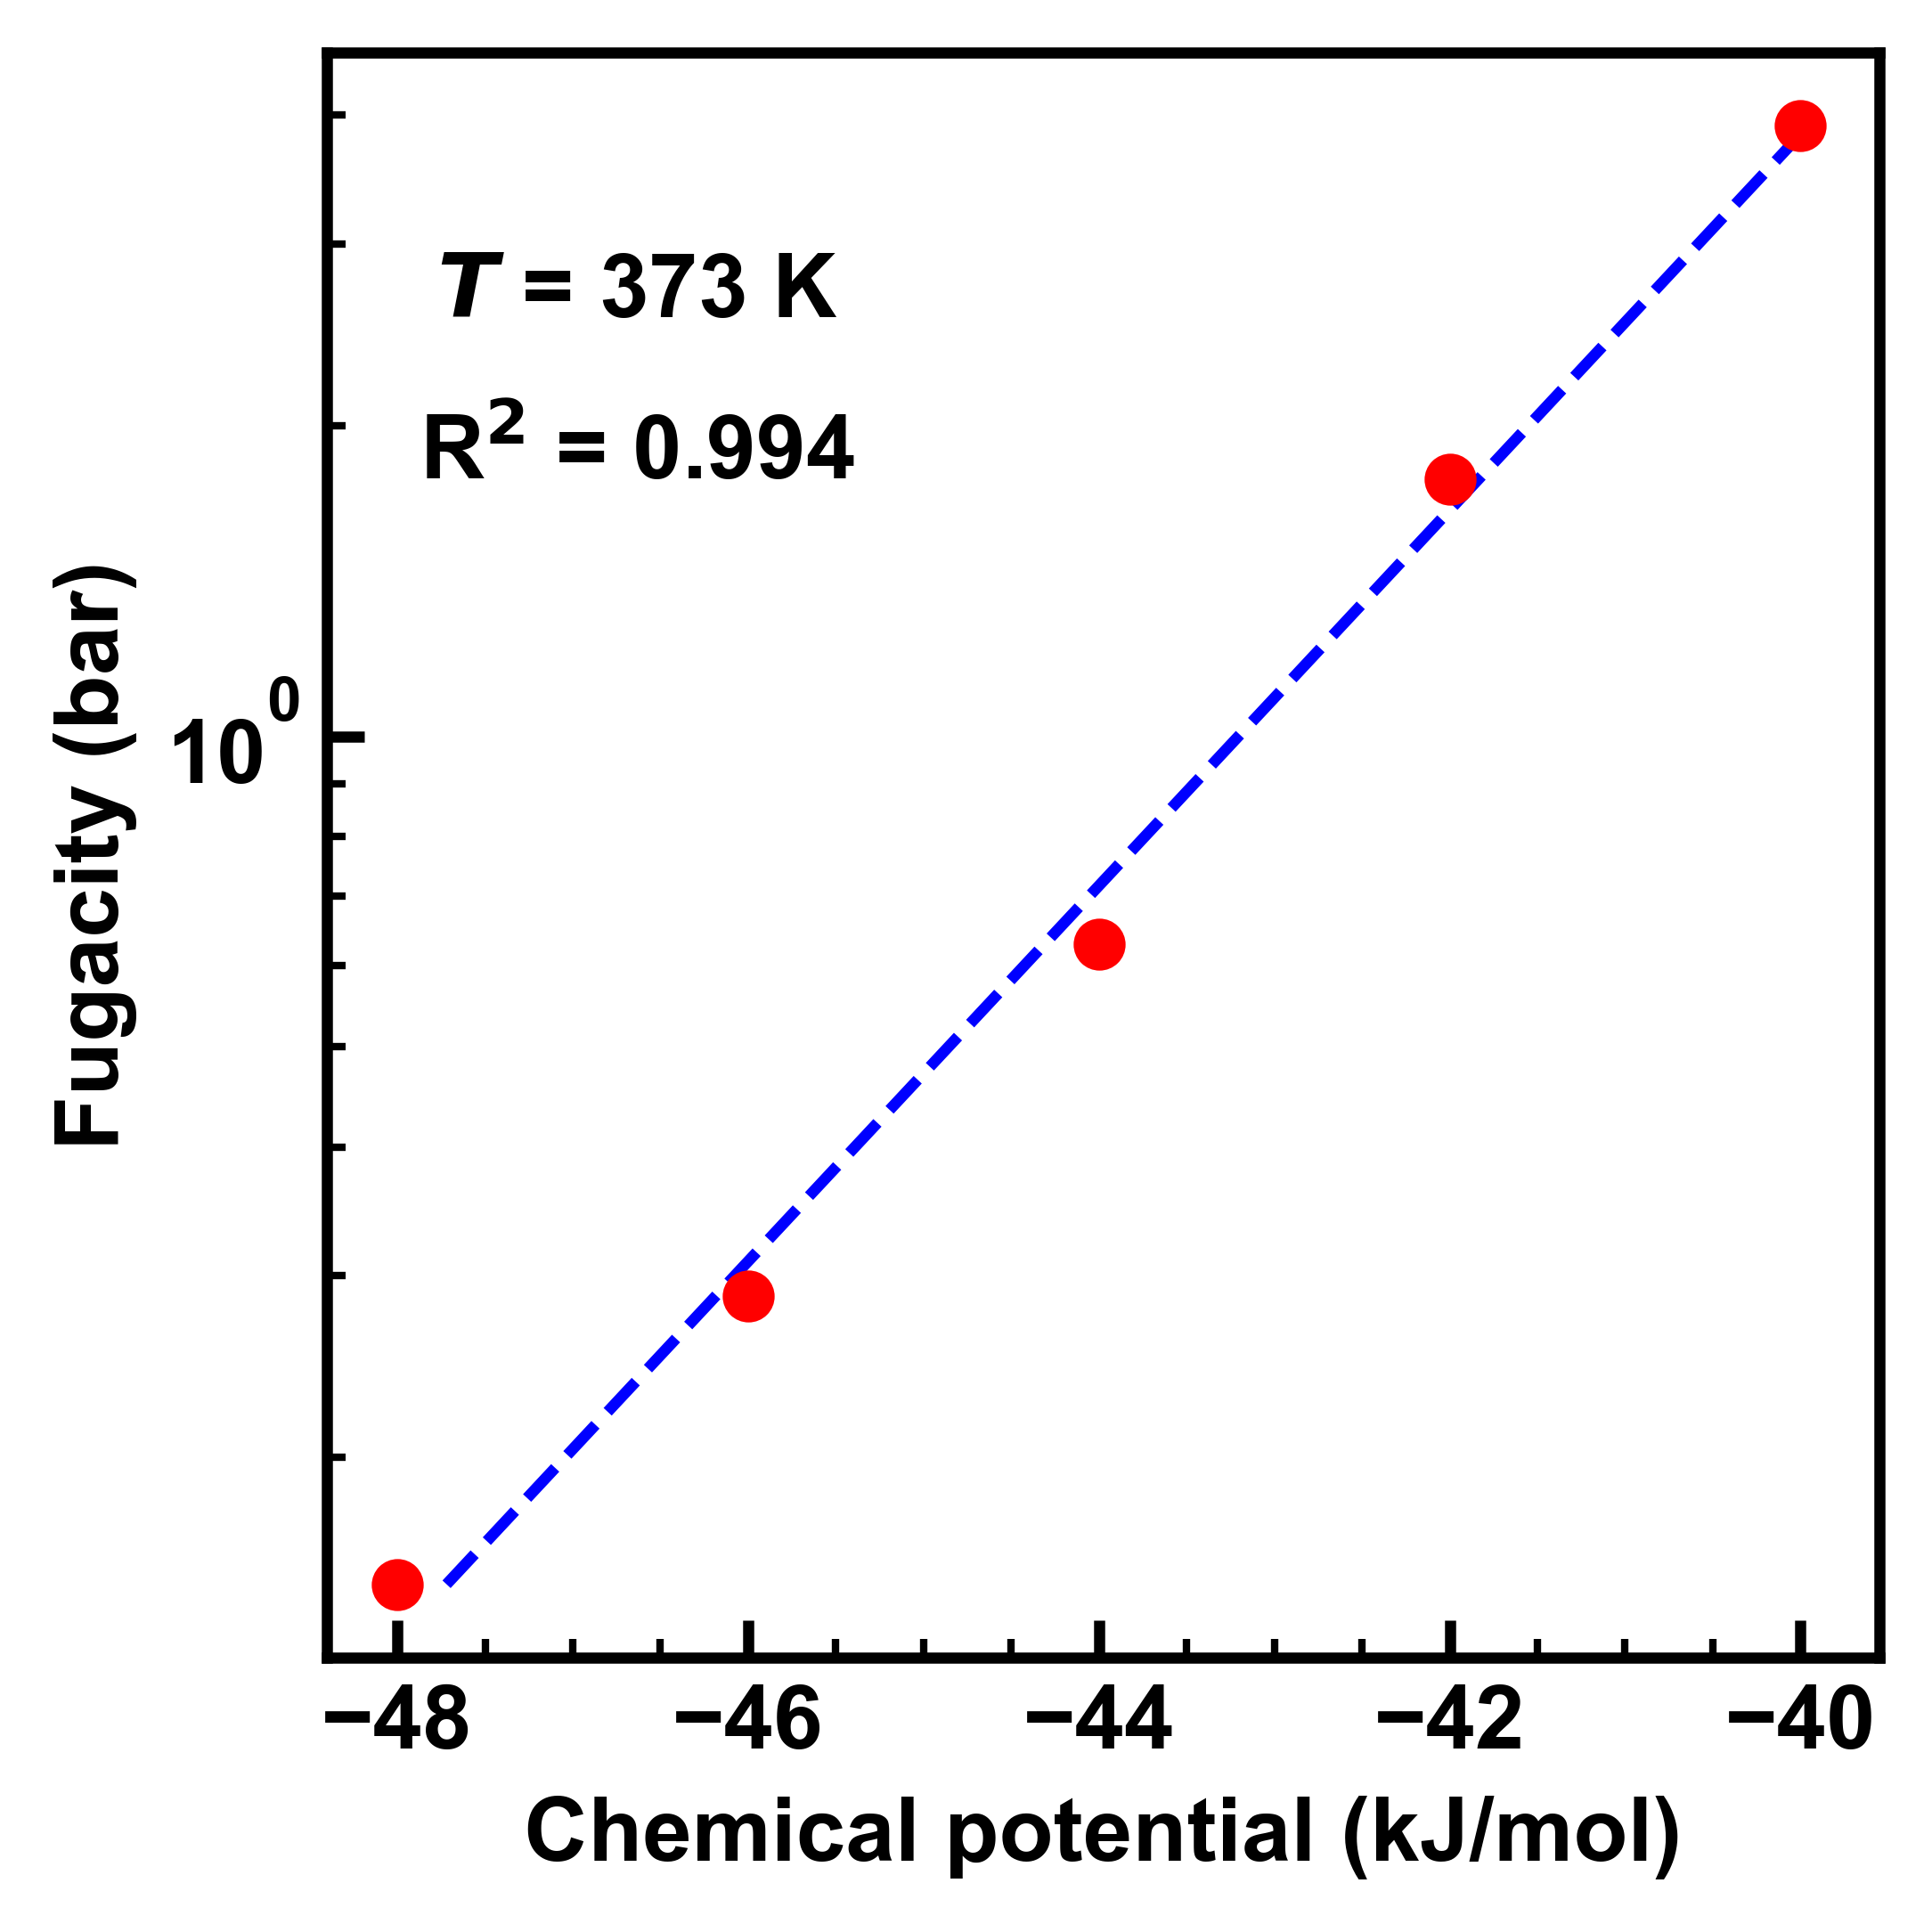

In [16]:


fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600, figsize = (3.5, 3.5), layout = "constrained")
slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())

mus_eos = (slope * np.log(pressures) + intercept) * u.kJ/u.mol
ax.plot(mus_eos, pressures, 'b--')

ax.plot(mus_adsorbate, pressures, 'ro')
ax.set_xlabel("Chemical potential (kJ/mol)")
ax.set_ylabel("Fugacity (bar)")
ax.set_yscale('log')


print(slope)
print(intercept)

ax.text(
        0.2, 0.85,
        f"$T$ = 373 K",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
    )


ax.text(
        0.2, 0.75,
        f"R$^2$ = {r_value * r_value:.3f}",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
    )

fig.savefig(f"{temperature}-eos.png", transparent = True)


In [17]:

pressures = [
    #6000   ,
    #22100  ,
    #49180  ,
    101325 , # 1 atmosphere
    #121800 ,
    #316800 ,
    #839700 ,
    #2243000,
    #6000000,
] * u.Pa

mus = (slope * np.log(pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
for (mu, pressure) in zip(mus, pressures):
    print(f"We will run at mu = {mu:0.2f} to simulate {pressure:0.0f}")


We will run at mu = -43.17 kJ/mol to simulate 101325 Pa


In [19]:
box_list = [zeolite]
species_list = [zeolite_ff, adsorbate_ff]

mols_in_boxes = [[1,0]]

system = mc.System(
    box_list,
    species_list,
    mols_in_boxes=mols_in_boxes,
)

moveset = mc.MoveSet('gcmc', species_list)


custom_args = {
  "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 14.0 * u.angstrom,
    "charge_cutoff": 14.0 * u.angstrom,
    "prop_freq": 4000,
    "coord_freq": 4000,
}

for (pressure, mu) in zip(pressures, mus):
    
    dirname = f"zeo_press_{pressure.value:0.0f}_T_{temperature:.1f}".replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=5000000,
            temperature=temperature,
            chemical_potentials = ["none", mu],
            **custom_args
        )

Treating <Structure 3456 atoms; 1 residues; 0 bonds; PBC (orthogonal); parameterized> as a non-insertable rigid species since it has no bonds
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


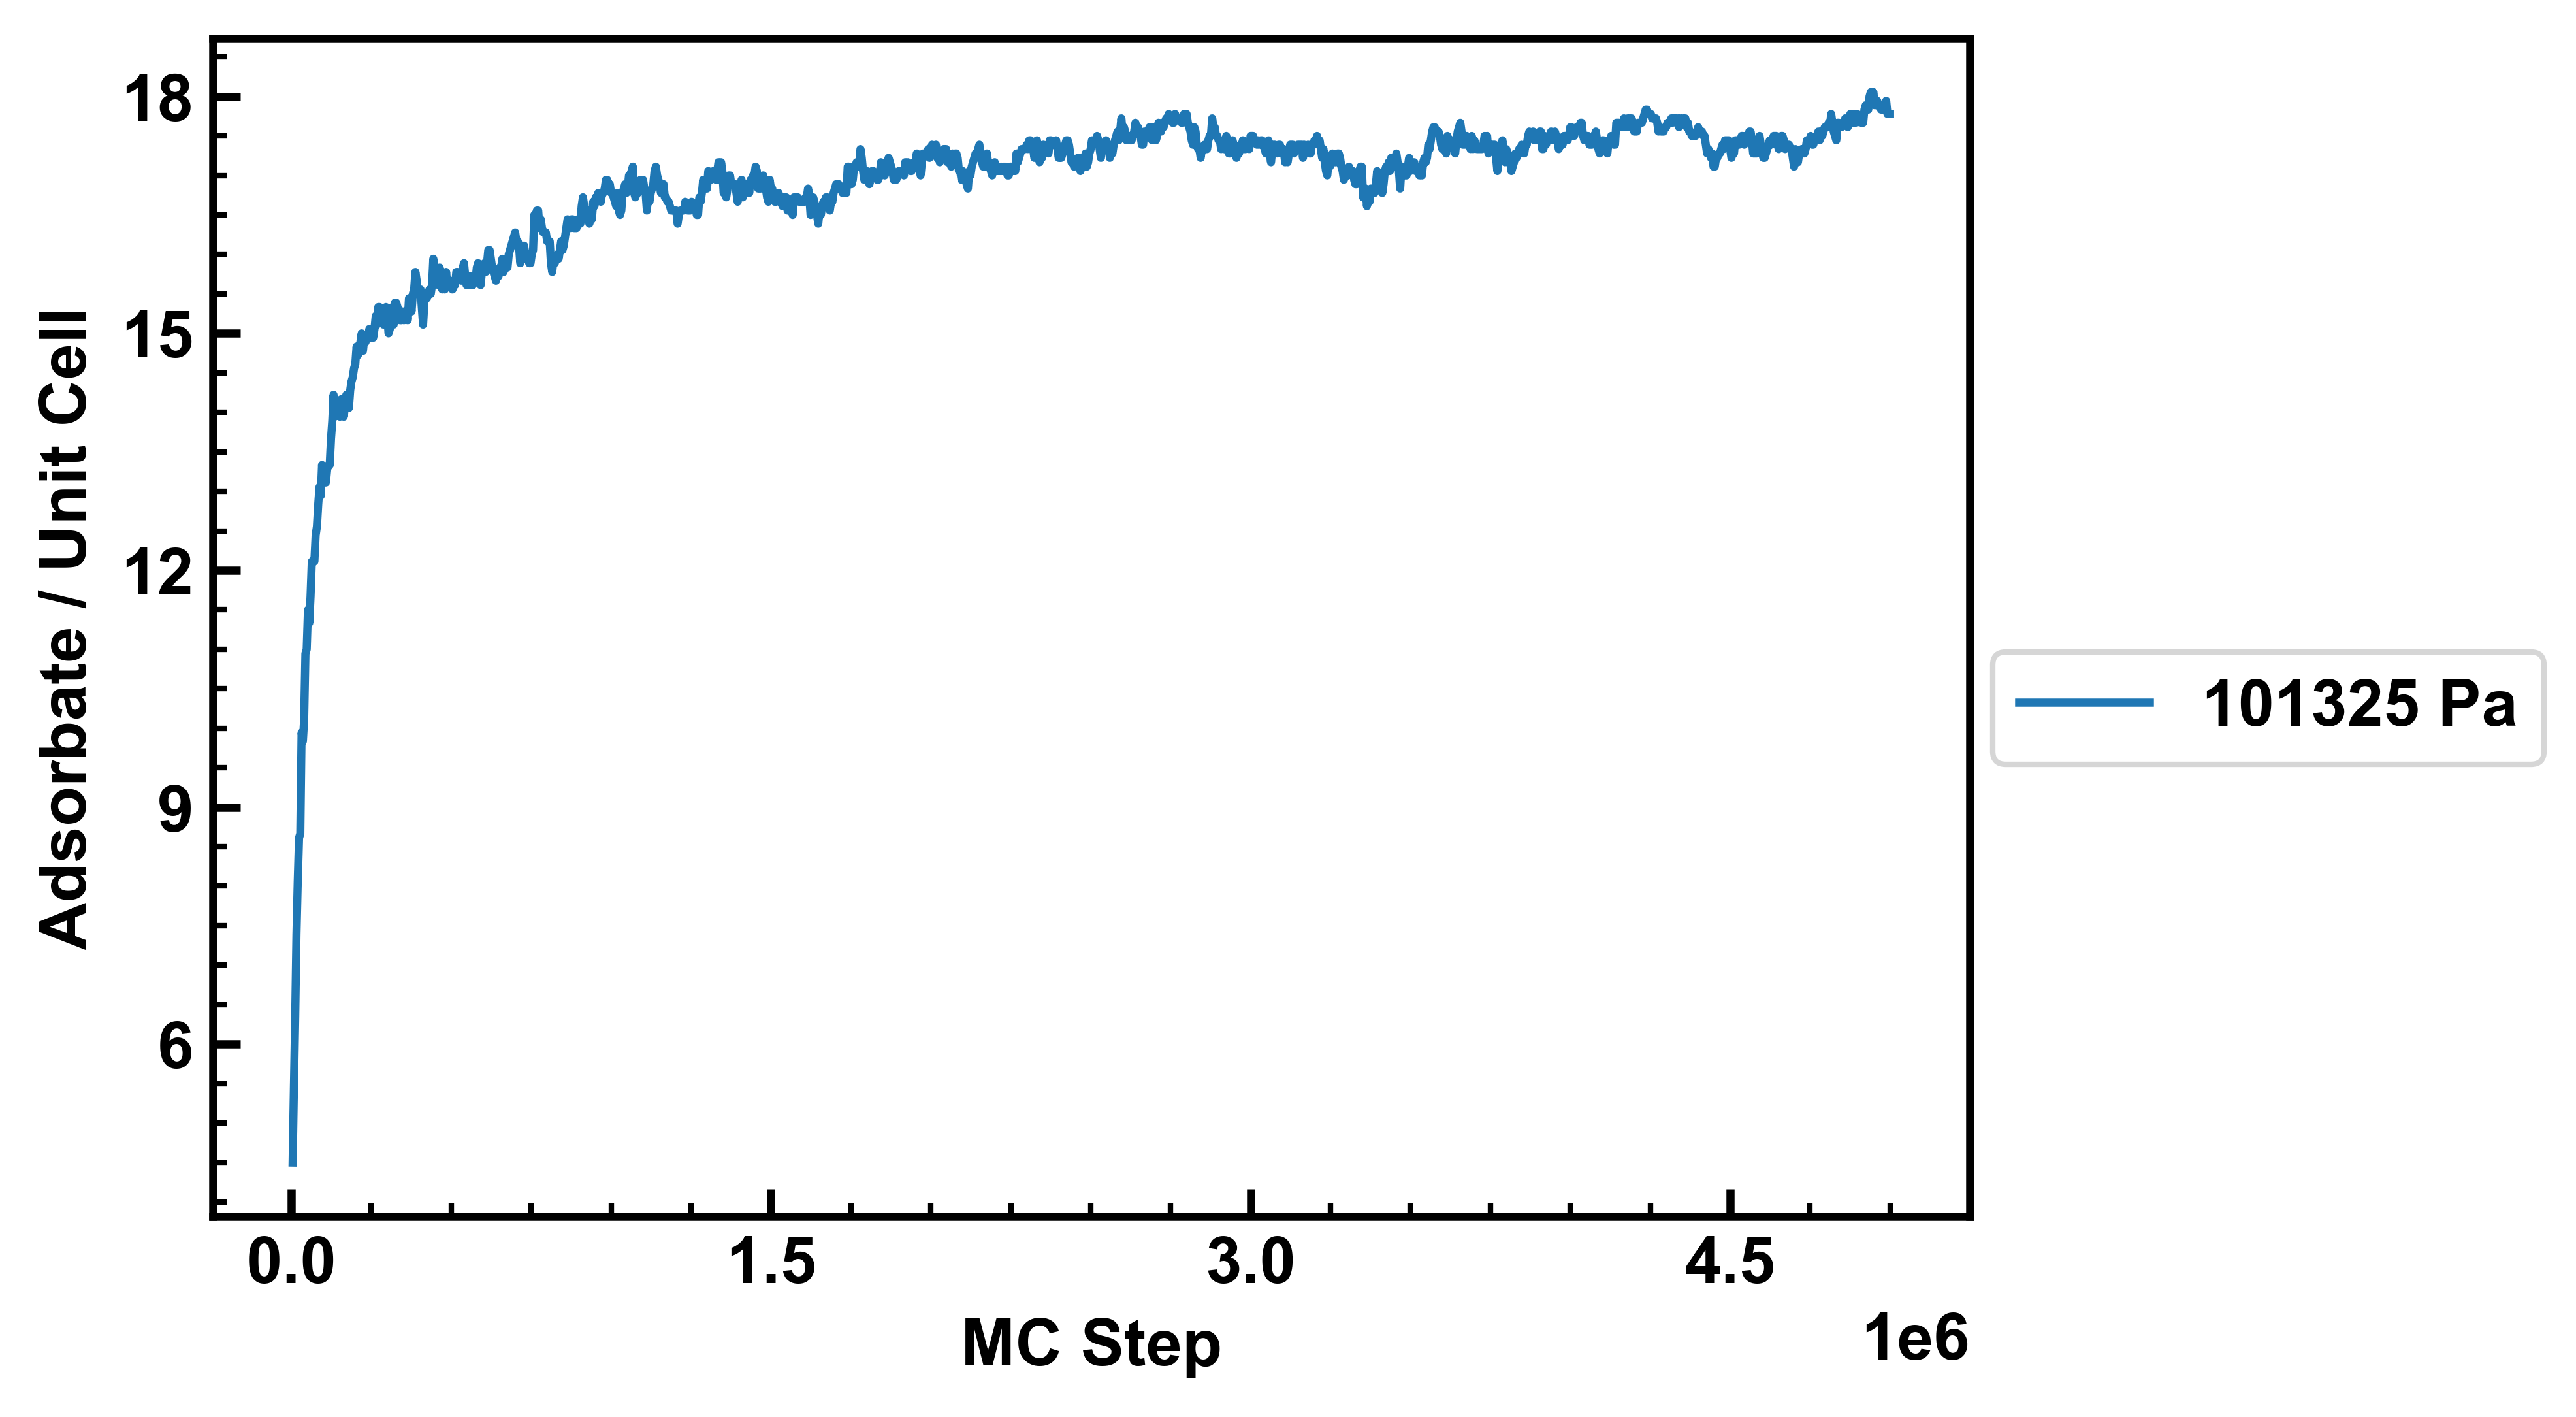

In [20]:

fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600, figsize = (6.5, 3.5), layout = "constrained")
loading = []
for pressure in pressures:
    dirname = f"zeo_press_{pressure.value:0.0f}_T_{temperature:.1f}".replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(f"{dirname}/gcmc.out.prp")
    n_unitcells = nx*ny*nz
    loading.append(np.mean(thermo.prop("Nmols_2", start=250000)/n_unitcells))
    ax.plot(thermo.prop("MC_STEP"), thermo.prop("Nmols_2")/n_unitcells, label=f"{pressure:0.0f}")
    
#ax.set_title(f"T = {temperature:0.1f}", fontweight="bold")
ax.set_xlabel('MC Step')

ax.set_ylabel('Adsorbate / Unit Cell')
set_ticks(ax,  xlinear=False, ylinear=False, xmax=True, ymax=True,)

fig.legend(loc='outside center right', ncol=1)
fig.savefig(f"{temperature}-loading.png", transparent = True)

101325 Pa 17.039655817433594 dimensionless


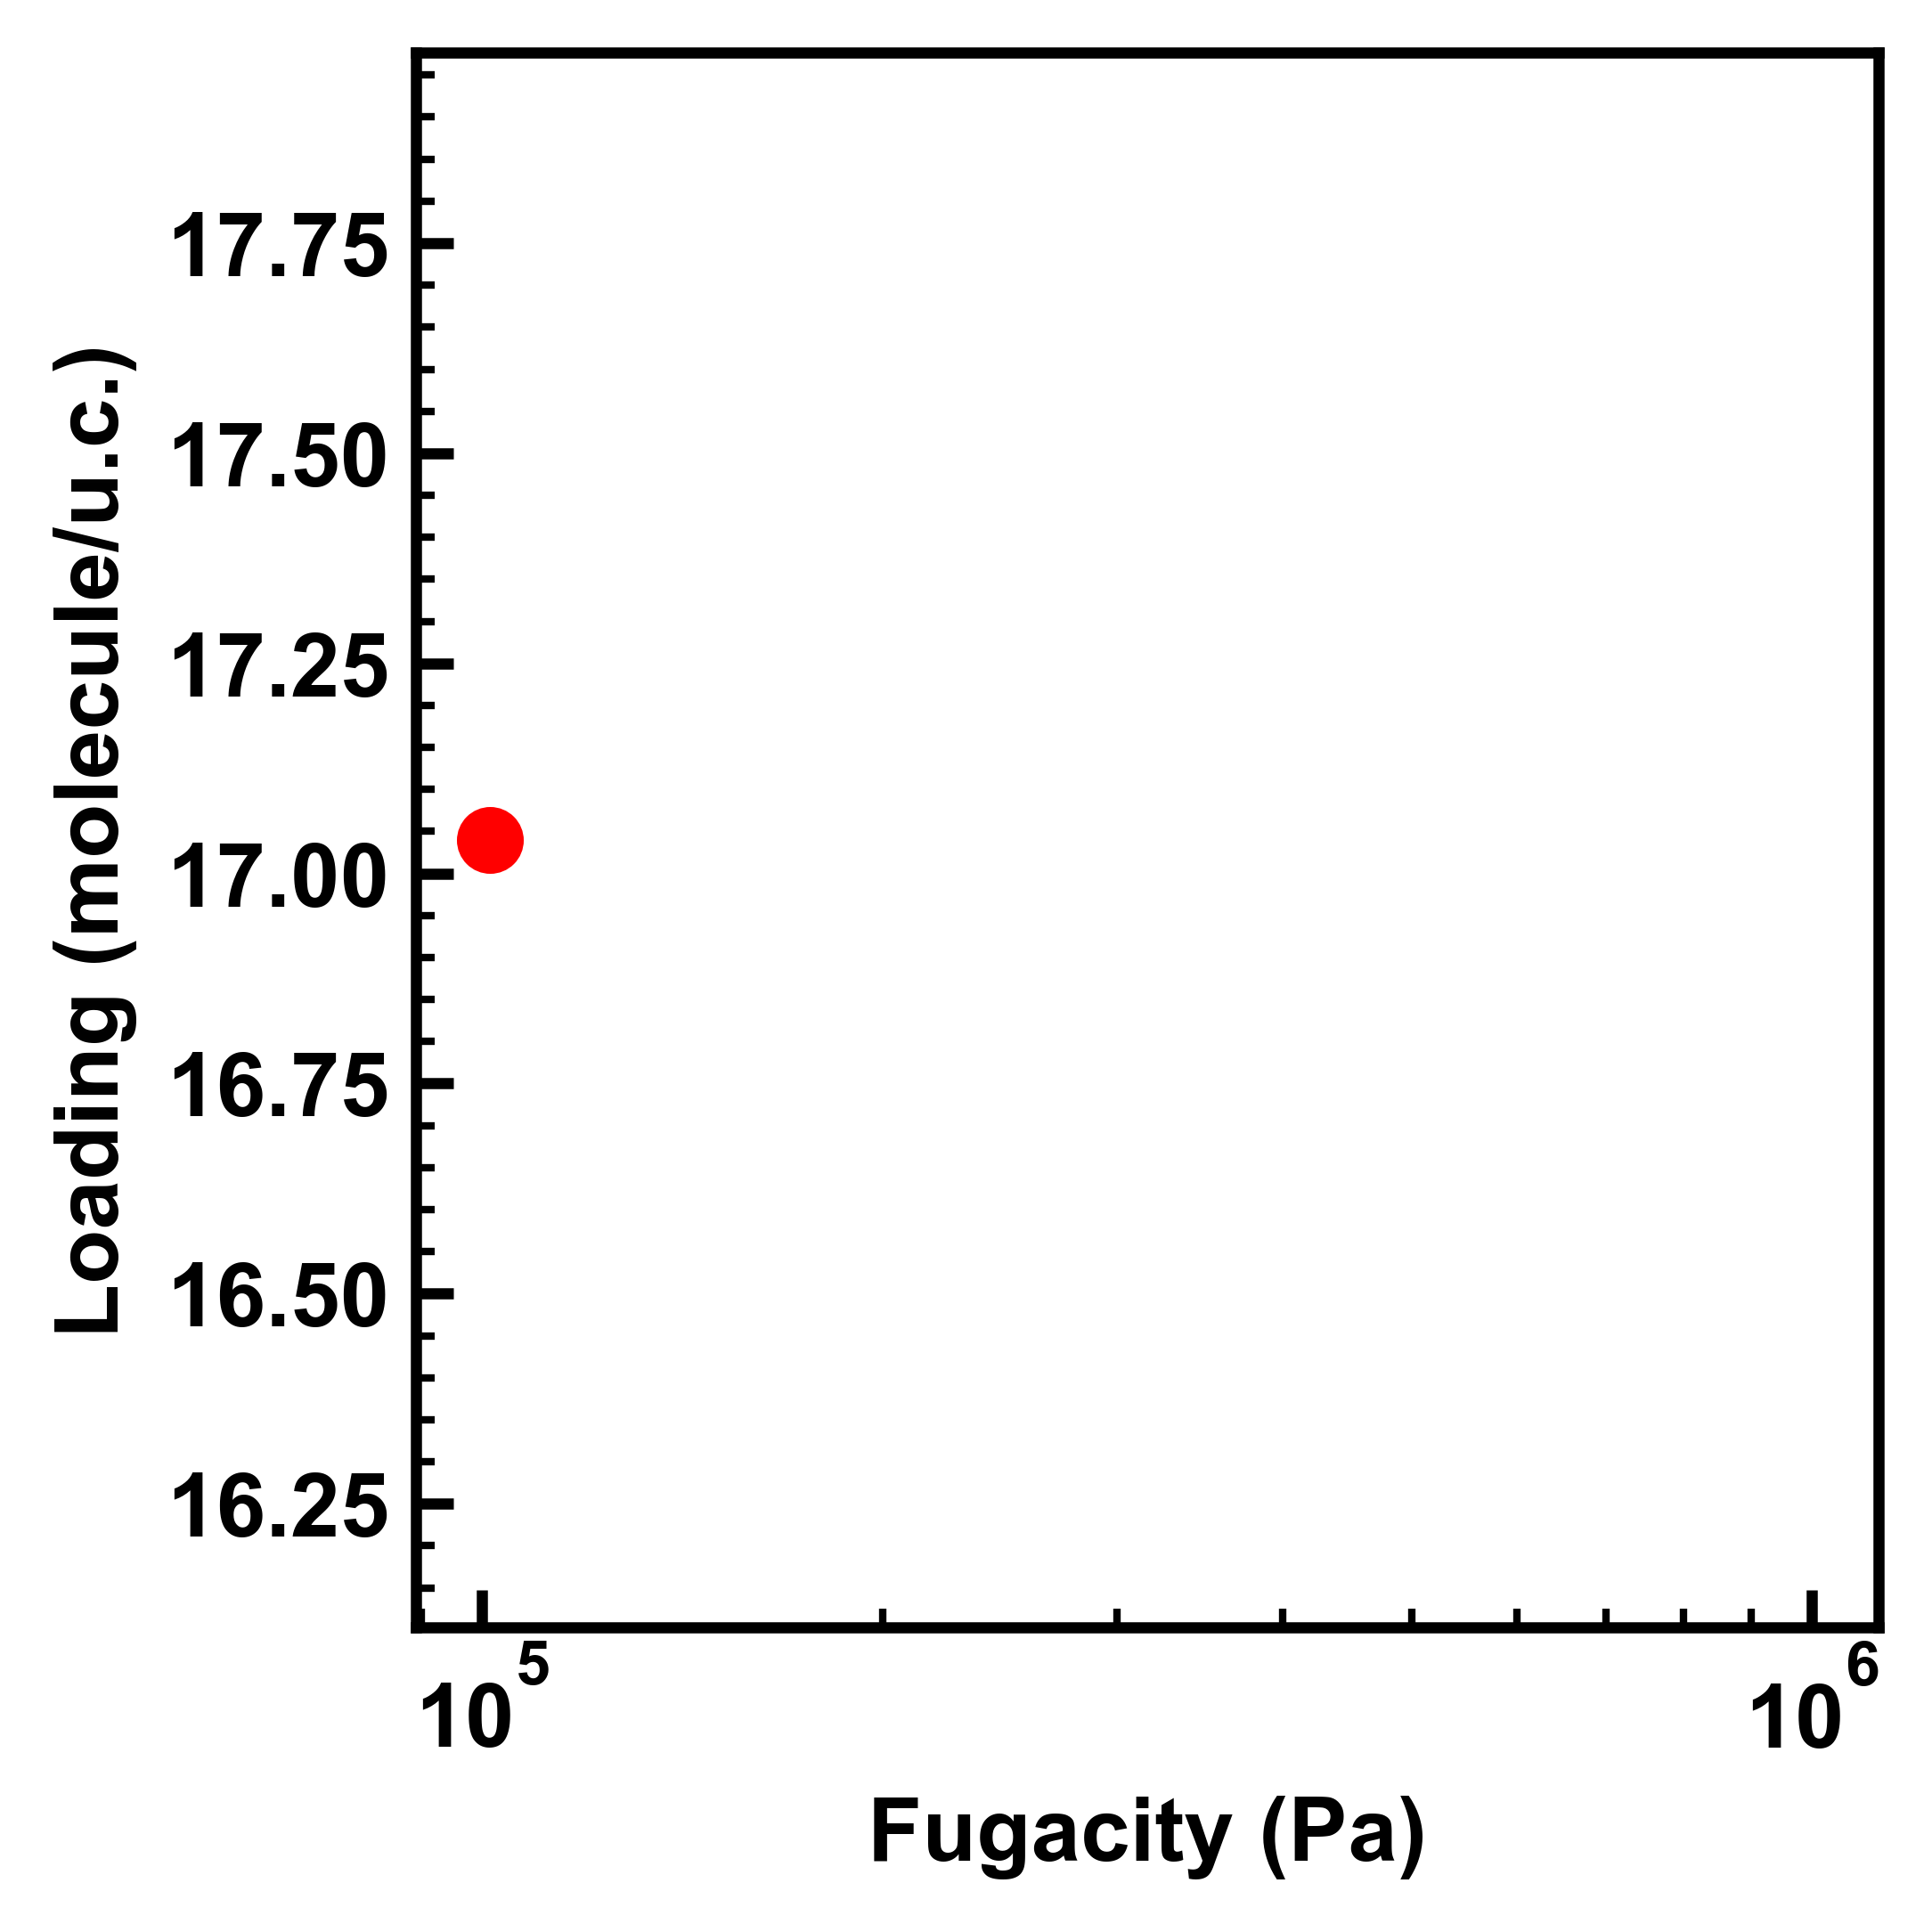

In [21]:
#published_results = np.genfromtxt('resources/lit_results/tzeo_MFI-methane_308K.txt', skip_header=3)
#plt.plot(published_results[:,0], published_results[:,1], 'bs', markersize=8, label="Siepmann 2013")
fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600, figsize = (3.5, 3.5), layout = "constrained")

for p, l in zip(pressures, loading):
    print(p, l)

ax.plot(pressures, loading, 'ro-', markersize=8)
#plt.title("Comparison with literature")
ax.set_xlabel("Fugacity (Pa)")

ax.set_ylabel("Loading (molecule/u.c.)")
ax.set_xscale("log")

fig.savefig(f"{temperature}-isotherm.png", transparent = True)
